## Exploring UMAP

In [2]:
%cd /nethome/bdevnani3/vis_lang/continual/src/

from model_wrapper import Bert
from models import alexnet
import torch
import torch.nn as nn
import numpy as np


from dataloaders import cifar100 as datagenerator
from omegaconf import OmegaConf
from main import init_root, cifar100_class_names

from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

/nethome/bdevnani3/vis_lang/continual/src
In /nethome/bdevnani3/anaconda3/envs/p3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /nethome/bdevnani3/anaconda3/envs/p3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /nethome/bdevnani3/anaconda3/envs/p3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /nethome/bdevnani3/anaconda3/envs/p3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will

In [15]:
RUN = 0

# Set up dataloader
args = OmegaConf.load("./configs/cifar100_bert_icl_itl.yml")
args.data_dir = init_root()
args.ntasks = 20 
args.seed = RUN
dataloader = datagenerator.DatasetGen(args)
taskcla= dataloader.taskcla

In [16]:
from collections import OrderedDict
MODEL_RANGE = 2
NUM_EMBEDDINGS_PER_CLASS = 100

embs = []
tgts = []
expt_path = f"/nethome/bdevnani3/raid/continual/cifar100_alexnet_bert_icl_itl/run_{RUN}/"

for model in range(MODEL_RANGE+1):
#Load model
    net = alexnet.AlexNet(768)
    appr = Bert(model=net, class_names=cifar100_class_names)
    state = torch.load(f"{expt_path}model_{model}.pth", map_location=torch.device('cpu'))
    appr.model.load_state_dict(state["net"])
    appr.model.eval()

    class_names = []
    class_embeddings = []
    targets = {}
    embeddings = OrderedDict()
    task_ids = []

    for task_set in range(0, model+1):
        dataset = dataloader.get(task_set)
        print(set(dataset[task_set]["train_labels"]))

        test_data_loader = dataset[task_set]['test']

        local_task_ids = list(set(dataset[task_set]["train_labels"]))
        task_ids.extend(local_task_ids)

        class_names.extend(np.array(appr.class_names)[local_task_ids])
        class_embeddings.extend(appr.model.word_lookup.cpu().numpy()[local_task_ids])

        for x in local_task_ids:
            embeddings[x] = []
            targets[x] = []

        classes_finished = 0

        for inputs, labels in test_data_loader:
            with torch.no_grad():
                embedding = appr.model(inputs).cpu().numpy()
                labels = labels.cpu().numpy()

            for i, label in enumerate(labels):
                if len(embeddings[label]) < NUM_EMBEDDINGS_PER_CLASS:
                    embeddings[label].append(embedding[i])
                    targets[label].append(label)
                    # Done with this class
                    if len(embeddings[label]) == NUM_EMBEDDINGS_PER_CLASS:
                        classes_finished += 1
            
            if classes_finished >= len(class_names):
                break
    print("-----------------------")
    print([k for k,v in embeddings.items()])
    print([k for k,v in targets.items()])
    print("-----------------------")
    emb_inp = np.concatenate([class_embeddings] + [np.stack(v, axis=0) for k,v in embeddings.items()], axis=0)
    tgts_inp = np.concatenate([task_ids] + [np.stack(v, axis=0) for k,v in targets.items()], axis=0)
    embs.append(emb_inp)
    tgts.append(tgts_inp)


Initializing stsb-bert-base...
Files already downloaded and verified
Files already downloaded and verified
Training set size:   2125 images of 32x32
Validation set size: 375 images of 32x32
Train+Val  set size: 2500 images of 32x32
Test set size:       500 images of 32x32
{2, 75, 86, 55, 26}
-----------------------
[2, 75, 86, 55, 26]
[2, 75, 86, 55, 26]
-----------------------
Initializing stsb-bert-base...
Files already downloaded and verified
Files already downloaded and verified
Training set size:   2125 images of 32x32
Validation set size: 375 images of 32x32
Train+Val  set size: 2500 images of 32x32
Test set size:       500 images of 32x32
{2, 75, 86, 55, 26}
Files already downloaded and verified
Files already downloaded and verified
Training set size:   2125 images of 32x32
Validation set size: 375 images of 32x32
Train+Val  set size: 2500 images of 32x32
Test set size:       500 images of 32x32
{73, 16, 54, 93, 95}
-----------------------
[2, 75, 86, 55, 26, 73, 16, 54, 93, 95]

In [17]:
concat = embs[0]
print(embs[0].shape)
for i in range(1,len(embs)):
    print(embs[i].shape)
    concat = np.concatenate((concat, embs[i]), axis=0)
concat.shape

(505, 768)
(1010, 768)
(1515, 768)


(3030, 768)

In [18]:
# Train the reducer
print(concat.shape)
reducer = umap.UMAP(metric='cosine', n_neighbors=20, min_dist=0.1)
model = reducer.fit(concat)

(3030, 768)


In [ ]:
sns.set(style='white', context='poster')
from matplotlib.pyplot import figure

figure(figsize=(8, 6))
plt.tick_params(left=False,
                bottom=False, 
                labelleft=False,
                labelbottom=False)
embedding= reducer.transform(embs[0])
plt.scatter(embedding[10:2010,0],embedding[10:2010,1], s=1, c=tgts[1][10:2010], cmap="Spectral", alpha=0.7)
plt.scatter(embedding[:5,0],embedding[:5,1], marker='^', c=tgts[1][:5], s=50, cmap="Spectral", edgecolor="k")

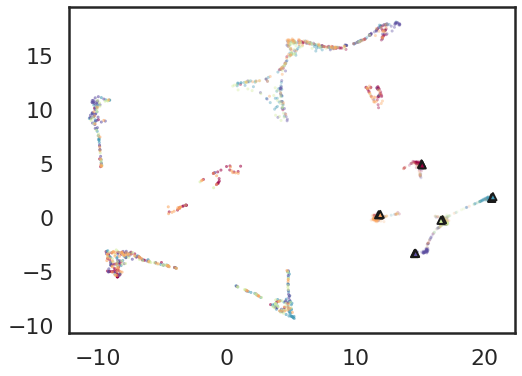

In [25]:
sns.set(style='white', context='poster')
from matplotlib.pyplot import figure
figure(figsize=(8, 6))
plt.tick_params(left=False,
                bottom=False)
tgts = np.array(tgts)
task = 0

for i in range(3):
    embedding= np.array(reducer.transform(embs[i]))
    if i ==0:
        st, end = 5*task, 5*(task+1)
        indices = list(range(st,end))
        plt.scatter(embedding[indices,0],embedding[indices,1], marker='^', c=tgts[i][indices], s=50, cmap="Spectral", edgecolor="k")
    st, end = 500*task + 5*(task+i+1), 500*(task+1) + 5*(task+i+1)
    indices = list(range(st,end))
    alpha = (i+1)*0.2
    plt.scatter(embedding[indices,0],embedding[indices,1], s=1, c=tgts[i][indices], cmap="Spectral", alpha=alpha)
plt.show()

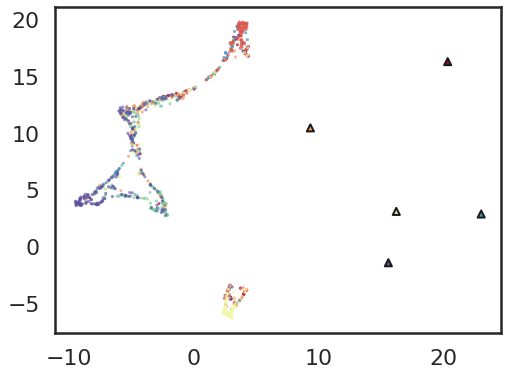

In [7]:
sns.set(style='white', context='poster')
from matplotlib.pyplot import figure

figure(figsize=(8, 6))
plt.tick_params(left=False,
                bottom=False, 
                labelleft=False,
                labelbottom=False)
embedding= reducer.transform(embs[1])
plt.scatter(embedding[10:2010,0],embedding[10:2010,1], s=1, c=tgts[1][10:2010], cmap="Spectral", alpha=0.7)
plt.scatter(embedding[:5,0],embedding[:5,1], marker='^', c=tgts[1][:5], s=50, cmap="Spectral", edgecolor="k")

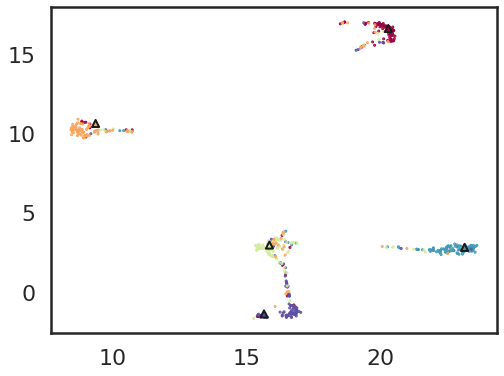

In [8]:
figure(figsize=(8, 6))
plt.tick_params(left=False,
                bottom=False)
embedding= reducer.transform(embs[0])
plt.scatter(embedding[:2000,0],embedding[:2000,1], s=1, c=tgts[0][:2000], cmap="Spectral")
plt.scatter(embedding[:5,0],embedding[:5,1], marker='^', c=tgts[0][:5], s=50, cmap="Spectral", edgecolor="k")

In [134]:
tgts[1][:10]

array([ 2, 75, 86, 55, 26, 73, 16, 54, 93, 95])

[ 2 75 86 55 26 73 16 54 93 95]


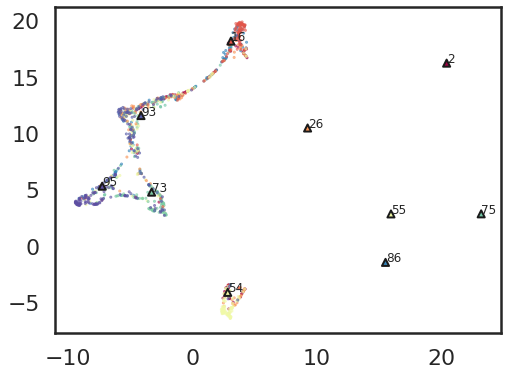

In [9]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6))
plt.tick_params(left=False,
                bottom=False)
embedding= reducer.transform(embs[1])
plt.scatter(embedding[:,0],embedding[:,1], s=1, c=tgts[1][:], cmap="Spectral", alpha=0.7)
n = 10 
print(tgts[1][:n])
plt.scatter(embedding[:n,0],embedding[:n,1], marker='^', c=tgts[1][:n], s=50, cmap="Spectral", edgecolor="k")
for j, name in enumerate(tgts[1][:n]):
    plt.annotate(name, (embedding[j,0] + 0.01, embedding[j,1] + 0.01), size=12)

In [14]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style='white', context='poster')

def plot_embs_by_task(task, num_models, embs, reducer):

    def axis_bounds(embedding):
        left, right = embedding[0].min(), embedding[0].max()
        bottom, top = embedding[1].min(), embedding[1].max()
        adj_h, adj_v = (right - left) * 0.1, (top - bottom) * 0.1
        return [left - adj_h, right + adj_h, bottom - adj_v, top + adj_v]

    fig, axs = plt.subplots(1,num_models, figsize=(1, 10))
    ax_bound = axis_bounds(embs)
    for i, ax in enumerate(axs.flatten()):
        print(i)
        embedding= np.array(reducer.transform(embs[i+task]))
        print(embedding.shape)
        current_target = np.array(tgts[i+task])
        st, end = 5*task, 5*(task+1)
        indices = list(range(st,end))
        print(embedding[indices, 0].shape)
        print(current_target[indices])
        ax.scatter(embedding[indices, 0], embedding[indices, 1], marker='^', c=current_target[indices], cmap="Spectral", alpha=0.7)
        st, end = 500*task + 5*(task+i+1), 500*(task+1) + 5*(task+i+1)
        indices = list(range(st,end))
        ax.scatter(embedding[indices, 0], embedding[indices, 1], s=6, c=current_target[indices], cmap="Spectral")
        ax.axis(ax_bound)
        ax.set(xticks=[], yticks=[])
    plt.tight_layout()

plot_embs_by_task(0,2, embs, reducer)

0
(505, 2)
1


KeyboardInterrupt: 